# Clustering Virtual Machine Behavior in a Cloud Environment: An Unsupervised Approach

## Introduction & Background

Virtual Machines (VMs) , commonly referred to as servers, are a virtual emmulation of a physical host where applications and services are ran. They are essentially a virtual representation of a computer, and are the backbone of many cloud services.

In a modern cloud enviornment, VMs are provisioned and destroyed many times over. Cloud Service Providers like Google Cloud, AWS, and Azure provison these resources to customers who utilize them to run their applications. Understanding the services and workload that are running on these VMs a crucial compoment of Cloud Management. **This project attempts to categorize VMs into clusters of similar behavior and workload pattern, using K-Means clustering, an unsuperivesd machine learning algorithm**

The reason a Cloud Service Provider, such as Azure, AWS, or GCP would want to understand or profile their behaivior, is so they could plan to deploy resources to these VMs accodringly. For example, if we know a specific group of VMs are very compute intensive, with low memory requirements, a Cloud Service provide may put these services on physical hosts that have a greater amount of CPU but less memory. 

The data used in this project comes from a pubilicly available dataset of different benchmark tests ran on 43,617 Azure VMs over a period of 483 days (https://github.com/Azure/AzurePublicDataset/tree/master/vm-noise-data). Microsoft used this dataset in a study and published their findings in a paper called TUNA (Tuning Unstable and Noisy Cloud Applications).The purpose of this study was to analyze the affect of performance management challenges via autotuning that arise when trying to manage a "noisy" cloud enviornment. Unlike the study where this data comes from, the goal of my project specifically is to cluster VM behaivior based on the data, rather than understand performance management challenges due to noise. 

Data Citations (also listed in references in bottom of doc):

Johannes Freischuetz, Konstantinos Kanellis, Brian Kroth, and Shivaram Venkataraman. 2025.
TUNA: Tuning Unstable and Noisy Cloud Applications.
In Proceedings of the Twentieth European Conference on Computer Systems (EuroSys '25).
Association for Computing Machinery, New York, NY, USA

## Library Imports

In [1]:
import pandas as pd
import psutil
import matplotlib.pyplot as plt
import requests, zipfile, io
import numpy as np
import pandas as pd
import seaborn as sns
import glob
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from mpl_toolkits.mplot3d import Axes3D


In [2]:
#!rm -rf vm-noise-data

In [3]:
# with zipfile.ZipFile("vm-noise-data.zip", "r") as z:
#     z.extractall("vm-noise-data")

In [4]:
# path = '/vm-noise-data/test_suite=perf-bench/test_name=Benchmark:_Epoll_Wait/vm_lifespan=short/vm_region=westus2/vm_sku=B8ms/unit=ops_sec.csv'
# df = pd.read_csv(path)
# df.head()

## Project Pipeline



1.0 EDA and Data Pre-processing  
    &emsp; 1.1 Data Load and Inspection  
    &emsp; 1.2 General Visualizations  
    &emsp; 1.3 Feature Engineering: Unique VM ID Tag  
    &emsp; 1.4 Feature Engineering: Summary Statistics Per test, Per Unique VM ID  
    &emsp; 1.5 Additional Data Visualizations  
    &emsp; 1.6 Quantifying Test/Metric Coverage  
    &emsp; 1.7 Final Dataframe Pruning  
    &emsp; 1.8 Data Pivot into Matrix   
    &emsp; 1.9 EDA Summary and Conclusion  

2.0 Modeling  
    &emsp; 2.1 PCA    
    &emsp; 2.2 K-Means Clustering with K= 4     
    &emsp; 2.3 Hyperparameter Tuning on K for K-Means, and Results of K-Means Modeling  
    &emsp; 2.4 Additional Modeling via GMM and Results of GMM  

3.0 Discussion of Results

4.0 Conclusion

5.0 References
    

# 1. EDA and Data Pre-processing

## Data Load and Inspection

The data from this project is stored in an unconvential manner across 198 separate .csv files, rather than in one combined file. The source that I pulled this from provided a sample code block that I slightly modified below to pull all this data from these files and create one single dataframe.

Using sample.ipynb excerpt from https://github.com/Azure/AzurePublicDataset/tree/master/vm-noise-data to load and create the dataframe

In [5]:
partition_headers = ["test_suite", "test_name", "vm_lifespan", "vm_region", "vm_sku", "unit"]
paths = glob.glob("." + "/**/*.csv", recursive=True)
partitions_raw = [[part for part in parts if any(p in part for p in partition_headers)] for parts in [path.split("/") for path in paths]]
partitions = [[p.split("=")[1].split(".")[0] for p in parts] for parts in partitions_raw]

In [6]:
dataframes = []
for partition in partitions:
    df = pd.read_csv(f"./{'/'.join([f'{h}={v}' for h, v in zip(partition_headers, partition)])}.csv")
    for h, v in zip(partition_headers, partition):
        df[h] = v
    if len(df) > 0:
        dataframes.append(df)
data = pd.concat(dataframes)
data

,value,runtime,starttime,VM_id,test_suite,test_name,vm_lifespan,vm_region,vm_sku,unit
0,92755.0,31.04,2024-02-02 22:37:31.130,0,perf-bench,Benchmark:_Epoll_Wait,short,westus2,B8ms,ops_sec
1,114346.0,31.04,2023-06-28 08:21:51.340,1,perf-bench,Benchmark:_Epoll_Wait,short,westus2,B8ms,ops_sec
2,105771.0,31.07,2024-02-02 23:15:36.920,2,perf-bench,Benchmark:_Epoll_Wait,short,westus2,B8ms,ops_sec
3,102340.0,31.03,2024-02-03 01:02:42.890,3,perf-bench,Benchmark:_Epoll_Wait,short,westus2,B8ms,ops_sec
4,105827.0,31.08,2024-02-03 03:10:37.920,4,perf-bench,Benchmark:_Epoll_Wait,short,westus2,B8ms,ops_sec
...,...,...,...,...,...,...,...,...,...,...
10436,53833.6,28.68,2023-08-05 16:51:49.380,2,Intel_Memory_Latency_Checker,Test:_Peak_Injection_Bandwidth_-_All_Reads,long,eastus,D8s_v5,MiB_s
10437,55107.7,28.42,2023-08-05 17:31:32.730,2,Intel_Memory_Latency_Checker,Test:_Peak_Injection_Bandwidth_-_All_Reads,long,eastus,D8s_v5,MiB_s
10438,55189.4,28.39,2023-08-05 19:46:11.760,2,Intel_Memory_Latency_Checker,Test:_Peak_Injection_Bandwidth_-_All_Reads,long,eastus,D8s_v5,MiB_s
10439,55231.9,28.36,2023-08-05 20:50:22.640,2,Intel_Memory_Latency_Checker,Test:_Peak_Injection_Bandwidth_-_All_Reads,long,eastus,D8s_v5,MiB_s


Describing the data and showing the dtype below. There are 9 columns in this data, with 7,037,220 rows, so this is quite a large dataset. Going from right to left, describing the columns below:

Value: The actual resulting value of the test run on this particular VM 

Runtime: The runtime of the particular test run on this VM

VM_ID: ID of the partulcar VM (Note: VM ID is not a unique value. It is only an ID specific to a VM region, VM SKU, or VM Lifespan, so this is something that will have to be adressed later during feature engineering. This means that one could have the same VM ID in westus2 and eastus region, so it is not necesarily a unique ID). 

test_suite: The category of test run on a VM

test_name: The specific test name run on each VM

vm_lifespan: Categorical label describing the VM lifespan. As noted in the github repository where this data came from, "long" running vms ran for the entirety of the study, while "short" running vms where ephemeral and only lasted for the duration of the benchmark test. This is typical of a cloud environment, where one has some long running vms and then "burstable" workloads that are ephemeral and short-lived. These are referred to as "Noisy VMs" in the original study done on this data.

vm_region: Region where the VM resides (either westus2 or eastus).

vm_sku: Type of VM that the workload ran on

unit: The unit measurement of the test that was ran (corresponds with value).


In [7]:
data.info()

data.describe()

data.isna().sum().sort_values(ascending = False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7037220 entries, 0 to 10440
Data columns (total 10 columns):
 #   Column       Dtype  
---  ------       -----  
 0   value        float64
 1   runtime      float64
 2   starttime    object 
 3   VM_id        int64  
 4   test_suite   object 
 5   test_name    object 
 6   vm_lifespan  object 
 7   vm_region    object 
 8   vm_sku       object 
 9   unit         object 
dtypes: float64(2), int64(1), object(7)
memory usage: 590.6+ MB


unit           0
vm_sku         0
vm_region      0
vm_lifespan    0
test_name      0
test_suite     0
VM_id          0
starttime      0
runtime        0
value          0
dtype: int64

No NaN values as shown above, but it does look like we have a Dtype that needs to be reconfigured. Currently starttime is stored as an object, and if it is used later in this notebook, it is more usefull to store as a datetime. 

Converting starttime to datetime below. 

In [8]:
data['starttime'] = pd.to_datetime(data['starttime'], errors = 'coerce')
if data['starttime'].isna().sum()>0:
    print('error')
else:
    print('conversion complete')

conversion complete


Now, looking at the total number of unique values per category below. We have a rich datset, with a total number of 79 unique tests run on VMs. This will be an important feature to note, and something we can use for modeling later on. 

In [9]:
for col in ['test_suite', 'test_name', 'vm_region', 'vm_sku', 'vm_lifespan']:
    print(f"{col}: {data[col].nunique()} unique vals")

test_suite: 8 unique vals
test_name: 79 unique vals
vm_region: 2 unique vals
vm_sku: 2 unique vals
vm_lifespan: 2 unique vals


## General Visualizations

In the bar chart below, total number of tests/values run per test suite is shown. This is an important thing to note as we move onto modelling, as not all test suites are represented equally. This will need to be addressed by either trimming off tests that are under-represented across the vm estate, or reducing the noise from over-represented tests. 

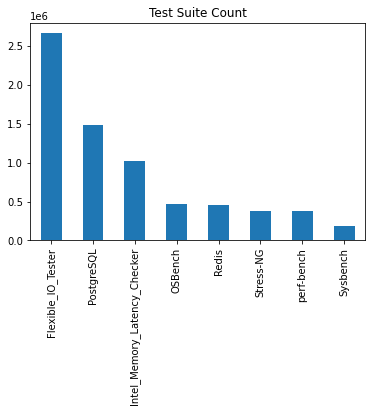

In [10]:
data['test_suite'].value_counts().plot(kind = 'bar', title = 'Test Suite Count')
plt.show()

The chart below shows us the total number of unique vms in the dataset, spread across each region, and shows the count of long lived vs short lived vms.

As one can see, there is a large difference between short-lived and long-lived VMs. So, while this is an important imbalance to note, this may not be the best feature to model off of, being that there is such a great imbalance. 

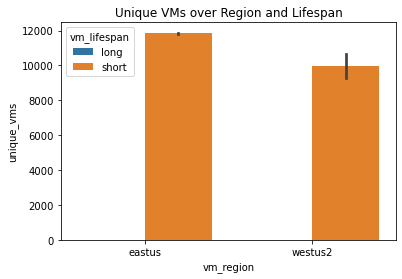

In [11]:
vm_count = (
    data.groupby(['vm_region', 'vm_sku', 'vm_lifespan'])['VM_id'].nunique().reset_index(name = 'unique_vms'))
plt.figure()
sns.barplot(data = vm_count, x ='vm_region',y = 'unique_vms', hue = 'vm_lifespan')
plt.title('Unique VMs over Region and Lifespan')
plt.show()

## Feature Engineering: Unique VM ID Tag

Now understanding that the end-goal is to perform clustering on these VMs, some feature engineering has to first take place to get this data in the right spot for clustering. The end result will be a matrix that clustering can be performed on. 

The first step that needs to be taken is to create the Unique VM ID feature. this feature is a combination of rows grouped by VM region, SKU, and Lifespan. As mentioned previously, the reason this must be done is becuase the current VM-ID is not actually a unique feature. It is only specific to the region, sku, or lifespan. For example, there could be two different VM ID: 1 in two different regions. Therefore, a feature must be created to have a unique vm id. 

The below code, first counts the total of unique VMs, and then creates the 'unique_vm_id' feature. 

In [12]:
print('Unique VM Total:',
data.groupby(['vm_region', 'vm_sku', 'vm_lifespan'])['VM_id'].nunique().sum())

Unique VM Total: 43629


In [13]:
data['vm_unique_id'] = (data['vm_region'] + '_' +
                       data['vm_sku'] + '_' +
                       data['vm_lifespan'] + '_' +
                       data['VM_id'].astype(str))
print('Unique VM Identifier Count: ', data['vm_unique_id'].nunique())

Unique VM Identifier Count:  43629


In [14]:
vm_time_count = (data.groupby('vm_unique_id')['starttime'].count().sort_values(ascending = False))

vm_time_count.describe()

count     43629.000000
mean        161.296844
std        5532.467449
min           1.000000
25%          63.000000
50%          83.000000
75%          83.000000
max      582288.000000
Name: starttime, dtype: float64

## Feature Engineering: Summary Statistics Per test, Per Unique VM ID

The next step of feature engineering is to create a set of summary statistics per test, per unique vm ID. Being that each test could have been run multiple times on a unique vm throughout the study (depending on if the vm was short-lived or long-lived), it is necesary to create summary statistics that will allow for the data to be summarized per test, per unique VM ID. Since this is not a temporal-based project, a summary statistic needs to be created to take time out of the data and reduce the data to just the necesary features.

The below code creates mean, std deviation, min, max, and p95 (a statistic that is very commonly used in cloud computing), for each unique VM ID and test. 

In [15]:
def p95(x):
    return np.percentile(x, 95)

In [16]:
vm_stats = (data.groupby(['vm_unique_id', 'test_name']).agg(
            value_mean = ('value', 'mean'),
            value_std = ('value', 'std'),
            value_min = ('value', 'min'),
            value_max = ('value', 'max'),
            value_p95 = ('value', p95),
            runtime_mean = ('runtime', 'mean'),
            runtime_std = ('runtime', 'std'),
            runtime_p95 = ('runtime', p95),
            rec_cnt = ('value', 'size')
            ).reset_index()
           )

In [17]:
metadata = (
data[['vm_unique_id', 'vm_lifespan', 'vm_region', 'vm_sku', 'unit']].drop_duplicates(subset = 'vm_unique_id'))



In [18]:
df_all = vm_stats.merge(metadata.reset_index(), on = 'vm_unique_id', how = 'left')
          

In [19]:
df_all.describe()

,value_mean,value_std,value_min,value_max,value_p95,runtime_mean,runtime_std,runtime_p95,rec_cnt,index
count,2.524251e+06,475182.000000,2.524251e+06,2.524251e+06,2.524251e+06,2.524251e+06,475182.000000,2.524251e+06,2.524251e+06,2.524251e+06
mean,2.937295e+05,15682.581441,2.915998e+05,2.967367e+05,2.963379e+05,1.767178e+02,4.852079,1.776105e+02,2.787845e+00,5.387576e+03
std,1.248671e+06,17143.716777,1.249107e+06,1.248074e+06,1.248136e+06,2.990788e+02,12.196027,2.988139e+02,1.000268e+02,3.207321e+03
min,3.200000e-02,0.000000,3.100000e-02,3.200000e-02,3.200000e-02,4.410000e+00,0.000000,4.410000e+00,1.000000e+00,0.000000e+00
25%,8.590000e+01,6292.992299,3.980000e+01,8.590000e+01,8.590000e+01,2.805000e+01,0.000000,2.805000e+01,1.000000e+00,2.636000e+03
50%,7.956570e+03,11014.548767,1.237750e+03,1.254996e+04,1.180504e+04,8.532667e+01,0.000000,8.533000e+01,1.000000e+00,5.309000e+03
75%,7.322289e+04,19452.594356,7.321567e+04,7.633245e+04,7.566001e+04,1.345500e+02,0.092376,1.345500e+02,1.000000e+00,8.008000e+03
max,1.253619e+07,123570.103703,1.253619e+07,1.258474e+07,1.255894e+07,6.038660e+03,470.002563,6.038660e+03,1.845100e+04,1.515600e+04


In [20]:
df_all.head()


,vm_unique_id,test_name,value_mean,value_std,value_min,value_max,value_p95,runtime_mean,runtime_std,runtime_p95,rec_cnt,index,vm_lifespan,vm_region,vm_sku,unit
0,eastus_B8ms_long_0,Benchmark:_Epoll_Wait,1.148372e+05,3552.964844,6.026700e+04,1.222950e+05,1.194479e+05,31.067307,0.061723,31.0900,1719,0,long,eastus,B8ms,ops_sec
1,eastus_B8ms_long_0,Benchmark:_Memcpy_1MB,1.548022e+01,0.458168,1.184351e+01,1.769726e+01,1.609565e+01,27.088853,0.703960,28.1315,1718,0,long,eastus,B8ms,ops_sec
2,eastus_B8ms_long_0,Benchmark:_Memset_1MB,4.650630e+01,2.686299,3.039313e+01,5.083160e+01,4.928856e+01,12.016760,0.373850,12.7100,1719,0,long,eastus,B8ms,ops_sec
3,eastus_B8ms_long_0,Benchmark:_Syscall_Basic,2.063561e+06,31470.006030,1.773723e+06,2.119996e+06,2.106908e+06,48.499150,0.747959,49.4700,1718,0,long,eastus,B8ms,ops_sec
4,eastus_B8ms_long_0,Scaling_Factor:_2500_-_Clients:_1_-_Mode:_Read...,2.315998e+03,71.289022,1.628000e+03,2.488000e+03,2.425000e+03,2020.819051,454.996080,2435.2600,1718,0,long,eastus,B8ms,ops_sec


In [21]:
df_all.columns
df_all.shape

(2524251, 16)

In [22]:
print(len(df_all))

2524251


## Additional Data Visualizations

Inserting a couple additional visualizations below now that vm stats have been calculated. The distribution plots below show that there is a strong left skew in the data, showing that there are some large outliers in the data on the right side of the distribution.

Additionally, the correlation matrix below shows highly correlated features, and those that are correlated are not too much of a surprise so this is not necesarily surprising to see. 

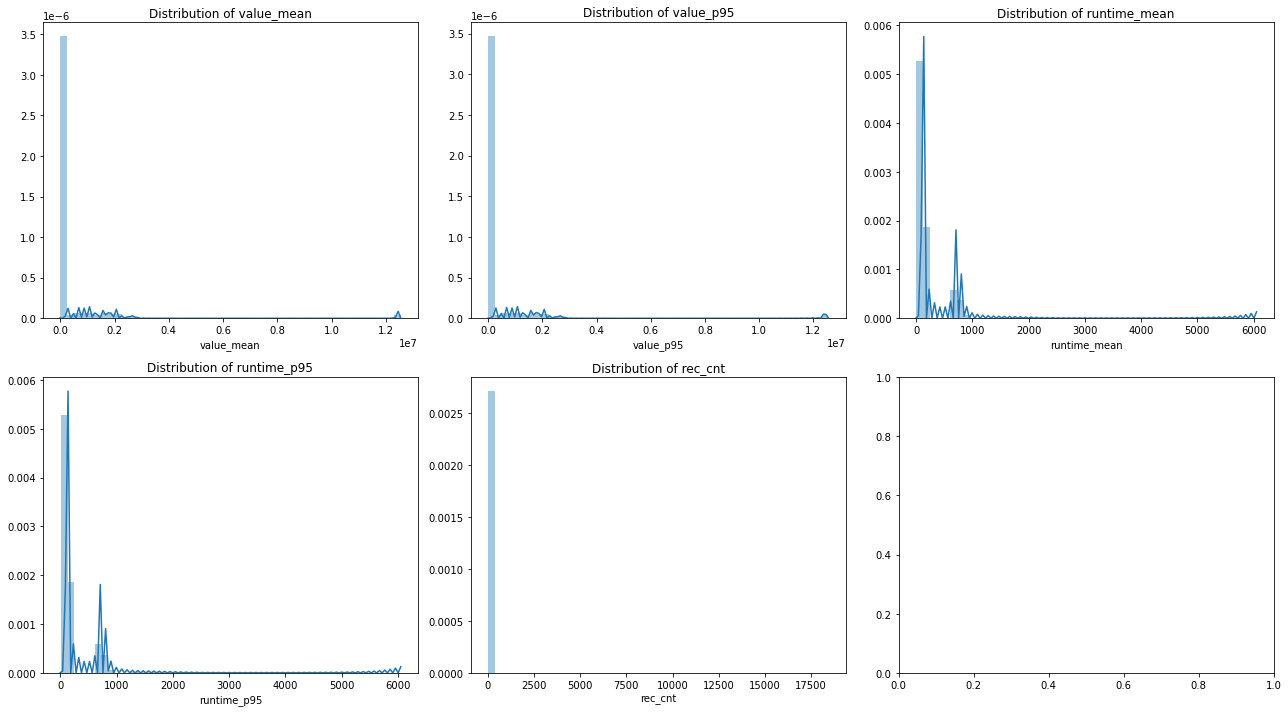

In [55]:
fig, axes = plt.subplots(2, 3, figsize =(18,10))
vis = df_all[['value_mean', 'value_p95', 'runtime_mean', 'runtime_p95', 'rec_cnt']].copy()
axes= axes.flatten()
for i, col, in enumerate (['value_mean', 'value_p95', 'runtime_mean', 'runtime_p95', 'rec_cnt']):
    sns.distplot(vis[col], bins = 50,
                ax = axes[i], kde = True)
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    
plt.tight_layout()
plt.show()

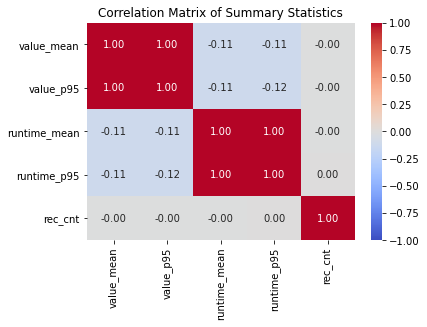

In [57]:
plt.figure()
sns.heatmap(vis.corr(), annot = True, fmt = '.2f', cmap = 'coolwarm', vmin = -1, vmax = 1)
plt.title('Correlation Matrix of Summary Statistics')
plt.show()

## Quantifying Test/Metric Coverage

The final step that needs to be taken before this data can be pivoted into a matrix is to quantify the total test coverage across each unique VM, and prune out those tests that do not have near-full coverage. This step is necesary because tests that have low coverage across the VMs will be underrepresented from a weighting standpoint when modeling is done.

The below code first quantifies the coverage percentage of tests that have been run on the VMs in the datset. If a test has been run on all the VMs in the dataset it is 100% coverage, and if it has been run on zero of the VMs it is 0% coverage. Below all tests that dont have greater than 99% coverage are dropped. This is important as it allows for equal balancing of test weights when applied to modeling later on. As there are an abundance of tests that were ran on this data, it is acceptable to drop those without 99% or greater coverage. 

In [23]:
met_cov = (vm_stats.groupby('test_name')['vm_unique_id'].nunique().sort_values(ascending = False)
          .to_frame('vm_count'))

met_cov['cov_pct'] = 100* met_cov['vm_count']/(data['vm_unique_id'].nunique())

met_cov.head(20)

,vm_count,cov_pct
test_name,,
Scaling_Factor:_25_-_Clients:_1_-_Mode:_Read_Write_(TPC-B_Like),43620,99.979372
Scaling_Factor:_25_-_Clients:_1_-_Mode:_Read_Write_(TPC-B_Like)_-_Average_Latency,43620,99.979372
Benchmark:_Epoll_Wait,43619,99.977079
Scaling_Factor:_25_-_Clients:_25_-_Mode:_Read_Only,43616,99.970203
Scaling_Factor:_25_-_Clients:_25_-_Mode:_Read_Only_-_Average_Latency,43616,99.970203
Test:_Create_Processes,43615,99.967911
Test:_CPU,43615,99.967911
Test:_SET_-_Parallel_Connections:_50,43615,99.967911
Test:_Idle_Latency,43614,99.965619


The below chart shows all the tests that do not have 99% or greater coverage across all VMs. As one can see, 28 out of the 79 total tests do not have full coverage. These will be removed before pivotting the data into a matrix. 

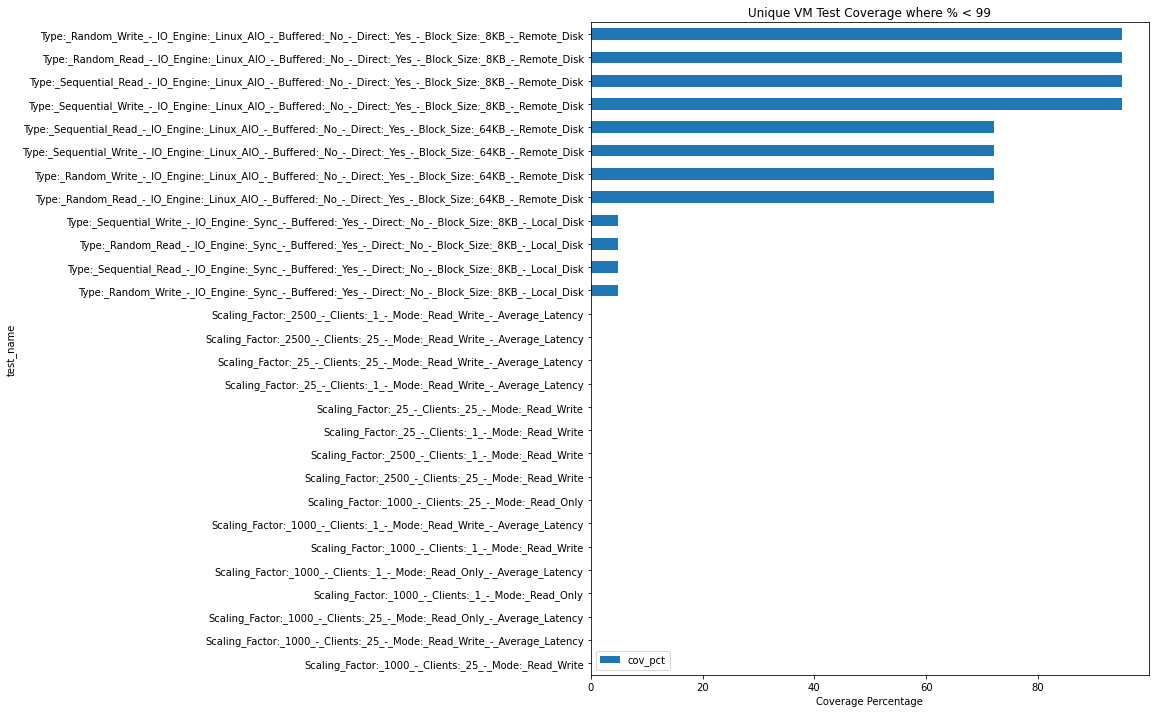

In [24]:
cov_cht = (met_cov[met_cov['cov_pct']<99]
                   .sort_values('cov_pct')
                   .plot(kind = 'barh',figsize = (10, 12), 
                         y = 'cov_pct', title = "Unique VM Test Coverage where % < 99"))
                
cov_cht.set_xlabel('Coverage Percentage')
plt.show()

## Final Dataframe Pruning

This code simply prunes the dataset of tests that do not have near full coverage (>90%) across all VMS. They will not be included in modeling.

In [25]:
test_99 = met_cov[met_cov['cov_pct'] > 99].index.tolist()
print('Tests to Be Included with >99% Coverage: ', len(test_99))

Tests to Be Included with >99% Coverage:  51


In [26]:
df_99 = df_all[df_all['test_name'].isin(test_99)].copy()
df_99.shape

(2223907, 16)

## Data Pivot into Matrix

As mentioned previously, to begin modelling on this data, it needs to be in the form of an NxM matrix. As one can see below the data is now pivotted into this matrix, with the index column being the unique VM ID, with each resulting column being the test run on this VM. The values in the matrix represent the P95 of the resulting test run on the VM. 

P95 was specifically chosen as the metric of choice for this matrix as it is a common summary statistic used in cloud computing. This is because averages can often mask "peak" behaivior that commonly occurs with cpu, mem, and IO. 

In [27]:
matrix= df_99.pivot_table(index = 'vm_unique_id', columns = 'test_name', values = 'value_p95')
matrix.head()

test_name,Benchmark:_Epoll_Wait,Benchmark:_Memcpy_1MB,Benchmark:_Memset_1MB,Benchmark:_Syscall_Basic,Scaling_Factor:_2500_-_Clients:_1_-_Mode:_Read_Only,Scaling_Factor:_2500_-_Clients:_1_-_Mode:_Read_Only_-_Average_Latency,Scaling_Factor:_2500_-_Clients:_1_-_Mode:_Read_Write_(TPC-B_Like),Scaling_Factor:_2500_-_Clients:_1_-_Mode:_Read_Write_(TPC-B_Like)_-_Average_Latency,Scaling_Factor:_2500_-_Clients:_25_-_Mode:_Read_Only,Scaling_Factor:_2500_-_Clients:_25_-_Mode:_Read_Only_-_Average_Latency,...,Test:_Peak_Injection_Bandwidth_-_3:1_Reads-Writes,Test:_Peak_Injection_Bandwidth_-_All_Reads,Test:_Peak_Injection_Bandwidth_-_Stream-Triad_Like,Test:_RAM__Memory,Test:_SADD_-_Parallel_Connections:_50,Test:_SET_-_Parallel_Connections:_50,Type:_Random_Read_-_IO_Engine:_Sync_-_Buffered:_Yes_-_Direct:_No_-_Block_Size:_8KB_-_Remote_Disk,Type:_Random_Write_-_IO_Engine:_Sync_-_Buffered:_Yes_-_Direct:_No_-_Block_Size:_8KB_-_Remote_Disk,Type:_Sequential_Read_-_IO_Engine:_Sync_-_Buffered:_Yes_-_Direct:_No_-_Block_Size:_8KB_-_Remote_Disk,Type:_Sequential_Write_-_IO_Engine:_Sync_-_Buffered:_Yes_-_Direct:_No_-_Block_Size:_8KB_-_Remote_Disk
vm_unique_id,,,,,,,,,,,,,,,,,,,,,
eastus_B8ms_long_0,119447.90,16.095654,49.288560,2106908.3,2425.00,0.45500,583.75,1.88675,10846.0,2.353,...,79698.620,79832.370,74998.740,7321.8795,1322001.587,1.166313e+06,1199.000,48400.0,74641.5700,68400.000
eastus_B8ms_long_1,94584.65,16.076272,48.776614,1294777.3,2339.70,0.46800,596.00,1.84600,10337.0,2.469,...,91972.455,90294.085,88553.215,7307.9340,1299263.559,1.150550e+06,1237.000,47100.0,72905.1585,67400.000
eastus_B8ms_long_2,121603.00,16.246153,49.138622,2092517.7,2476.15,0.46415,616.00,1.86500,10788.0,2.375,...,90606.970,91180.160,87494.690,7436.5375,1320089.481,1.166777e+06,1215.000,49000.0,78173.6225,68800.000
eastus_B8ms_short_0,119218.00,15.424336,46.356182,2048183.0,2198.00,0.45500,533.00,1.87500,10900.0,2.294,...,89554.200,89982.400,86376.800,7348.0700,1365585.000,1.151352e+06,1337.692,43507.7,50295.9410,94037.315
eastus_B8ms_short_1,119733.00,15.610144,45.769552,2041978.0,2616.00,0.38200,622.00,1.60700,10855.0,2.303,...,90948.800,90238.300,89559.200,7090.5600,1357834.380,1.227046e+06,1312.553,57830.1,47693.4190,63411.000


The below chart visualizes tha NaN values. Those values that are NaN (visualized as white in the below chart) are few and far between, but will need to be masked when modeling occurs. As one can see, this is a difficult thing to visualize as there is an abundance of VMs.

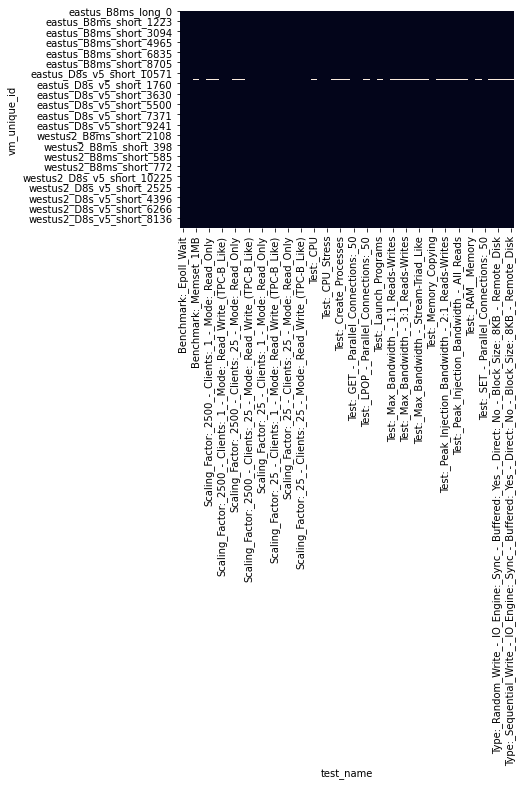

1172
0.0005267228714126554


In [28]:
plt.figure()
sns.heatmap(matrix.isna(), cbar = False)
plt.show()
print(matrix.isna().sum().sum())
print(matrix.isna().mean().mean())

## EDA Summary and Conclusion

The EDA executed in the above section revewaled some important dataset characteristics that has influenced the modeling approach below. 

The first thing it revealed was dataset structure. The raw data has over 7,000,000 records for 43,629 VMs, across 79 different VM tests. The tests are not evenly distributed across the test tuites, and vm lifespans are greatly imbalanced, with very few long living vms, and ver many short living vms. 

The second thing that was revealed was a need for feature engineering. All the featured VM-test pairs had to be summarized into specific statistics (mean, std, min,max, p95). These statistics will allow the model to take action on the data to draw actual conclusions. 

The third thing that was revealed was test coverage across VMs. There was not a full coverage of tests across all VMs, and because there was such a wealth of data to utilize it was decided to prune those tests that did not have >99% coverage.

Finally, it was revealed that the dataset needed to be pivoted into an NxM matrix. This allowed each VM to be represented by a 51 dimensional vector of p95 test results. This representation, provides a celan, high-dimensional feature spaces that will be extremely useful for unsupervised clustering (and PCA) below. 

# 2. Modeling

## PCA

The first step in the modeling pipeline that needs to be done is to perfotm PCA that will be referenced in further model visualizations below.  Being that the values in the matrix represent a wide variety of tests, these values must be standardized for the data to be usable. PCA allows one to avoid high-magnitude features from dominating the dataset, and helps provide principal components across standardized features.

PCA is a perfect tool for this problem. It will help reduce this higher dimension data, into a lower dimension space. The below code performs the PCA, and then shows an output of the explained variance in the values. 

In [29]:
X = matrix.copy()
X = X.fillna(X.mean(numeric_only = True))

X_s= StandardScaler().fit_transform(X)

X_sdf = pd.DataFrame(X_s, index = X.index, columns = X.columns)

pca = PCA(n_components = 2, random_state = 42)
X_pca = pca.fit_transform(X_sdf)


print('PCA Explained Variance: ', pca.explained_variance_ratio_.sum())


PCA Explained Variance:  0.6858817620946203


## K-Means Clustering with K= 4

As mentioned in the introduction, the main aim of this project is to perform Clustering on the data to see if distinguishable clusters can be separated from the feature set. The first step that was taken below was to use K-Means clustering (with K = 4) as a baseline cluster to be iterated upon with hyperparameter tuning later. 

In the modeling below, K-Means is used, with K= 4. Because there are no labels to this data, a silhoutte score is used to estimate the efficacy of the modeling performed. 

In [30]:
kmeans = KMeans(n_clusters = 4, n_init=10, random_state = 42)
labels = kmeans.fit_predict(X_sdf)

sil = silhouette_score(X_sdf, labels)

print('Shilouette Score: ', sil)

Shilouette Score:  0.4443696274404701


In [31]:
if not metadata.index.name == 'vm_unique_id':
    metadata = metadata.set_index('vm_unique_id')

cluster_ = (pd.DataFrame({'vm_unique_id': X.index, 'cluster': labels, 'pca_x': X_pca[:, 0], 'pca_y': X_pca[:, 1],
}).set_index('vm_unique_id').join(metadata, how = 'left'))


The below chart shows a visualization of the cluster groups in 2D, to show how the data was split. 

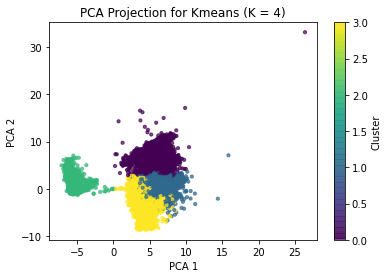

In [58]:
pca = PCA(n_components = 2, random_state = 42)
X_pca = pca.fit_transform(X_sdf)

plt.figure()
plt.scatter(X_pca[:, 0], X_pca[:, 1], c = cluster_['cluster'], cmap = 'viridis',s = 10, alpha = 0.7)

plt.title('PCA Projection for Kmeans (K = 4)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar(label = 'Cluster')
plt.show()

The below code, shows the top features (tests) that were present in each cluster of VMs. As one can see, there is a clear distinction between the top tests used and their resulting cluster groups. 

The meaning of this clustering is something that will be discussed further along in the Discussion of Results section

In [33]:
df_cluster = X_sdf.copy()
df_cluster['cluster'] = labels

cluster_means = (df_cluster.groupby('cluster').mean(numeric_only = True).T.sort_index())

clust_feat = (cluster_means.apply(lambda col: col.abs(), axis = 0).mean(axis=1).sort_values(ascending = False)
             .head(15))
# print('Top Feature Benchmarks Across Clusters', clust_feat)

In [34]:
for c in cluster_means.columns:
    print(f'\n Cluster {c}: Top 10 Features')
    display(cluster_means.loc[:, c].nlargest(10))


 Cluster 0: Top 10 Features


test_name
Scaling_Factor:_2500_-_Clients:_1_-_Mode:_Read_Write_(TPC-B_Like)_-_Average_Latency    2.257942
Scaling_Factor:_2500_-_Clients:_1_-_Mode:_Read_Only_-_Average_Latency                  2.054084
Scaling_Factor:_25_-_Clients:_25_-_Mode:_Read_Only_-_Average_Latency                   1.992151
Scaling_Factor:_25_-_Clients:_1_-_Mode:_Read_Only_-_Average_Latency                    1.782062
Test:_Create_Files                                                                     1.667758
Scaling_Factor:_25_-_Clients:_1_-_Mode:_Read_Write_(TPC-B_Like)_-_Average_Latency      1.616737
Test:_Idle_Latency                                                                     1.398850
Scaling_Factor:_25_-_Clients:_25_-_Mode:_Read_Write_(TPC-B_Like)_-_Average_Latency     1.268348
Test:_Memory_Allocations                                                               1.215821
Test:_Create_Processes                                                                 1.120937
Name: 0, dtype: float64


 Cluster 1: Top 10 Features


test_name
Test:_Launch_Programs                                                                1.304364
Test:_Create_Processes                                                               1.190135
Test:_Create_Threads                                                                 1.146323
Test:_Memory_Allocations                                                             1.128124
Scaling_Factor:_25_-_Clients:_1_-_Mode:_Read_Only_-_Average_Latency                  1.084766
Test:_Create_Files                                                                   1.081810
Scaling_Factor:_25_-_Clients:_1_-_Mode:_Read_Write_(TPC-B_Like)_-_Average_Latency    1.020686
Test:_Max_Bandwidth_-_All_Reads                                                      1.011355
Test:_Peak_Injection_Bandwidth_-_All_Reads                                           0.962999
Test:_Max_Bandwidth_-_3:1_Reads-Writes                                               0.948865
Name: 1, dtype: float64


 Cluster 2: Top 10 Features


test_name
Benchmark:_Syscall_Basic                                                                             0.968049
Test:_SADD_-_Parallel_Connections:_50                                                                0.940960
Test:_SET_-_Parallel_Connections:_50                                                                 0.939184
Test:_LPUSH_-_Parallel_Connections:_50                                                               0.935825
Benchmark:_Epoll_Wait                                                                                0.934865
Test:_RAM__Memory                                                                                    0.919188
Test:_GET_-_Parallel_Connections:_50                                                                 0.909982
Scaling_Factor:_25_-_Clients:_1_-_Mode:_Read_Only                                                    0.897245
Scaling_Factor:_25_-_Clients:_1_-_Mode:_Read_Write_(TPC-B_Like)                                      0.882139



 Cluster 3: Top 10 Features


test_name
Test:_Matrix_Math                                    1.528481
Test:_CPU_Stress                                     1.479268
Test:_Memory_Copying                                 1.467818
Test:_Peak_Injection_Bandwidth_-_All_Reads           1.161915
Test:_Max_Bandwidth_-_All_Reads                      1.161156
Test:_Peak_Injection_Bandwidth_-_3:1_Reads-Writes    1.071832
Test:_Max_Bandwidth_-_3:1_Reads-Writes               1.058969
Test:_Peak_Injection_Bandwidth_-_2:1_Reads-Writes    0.952325
Test:_Max_Bandwidth_-_2:1_Reads-Writes               0.949821
Test:_Max_Bandwidth_-_1:1_Reads-Writes               0.887510
Name: 3, dtype: float64

In [35]:
#cluster_means.loc[:, cluster_id].nlargest(10)

## Hyperparameter Tuning on K for K-Means, and Results of K-Means Modeling

After running the K-Means test for n_clusters = 4, hyperparameter tuning was done below to find the ideal number of clusters, that would create the most sensible grouping for this project. The below code cycles through n number of clusters (2-9) and provides a silhouette score, calinski harabasz score,a davies bouldin score, as well as measure inertia on each of these n values. 

As this data was originally not labeled, it is imperative to use these scores to assess the efficacy of each n_cluster value. This will be discussed further in the discussion of results section. 

In [36]:
k_s = range(2,9)
k_results = []

for k in k_s:
    kmeansn = KMeans(n_clusters = k, n_init = 10, random_state = 42)
    labeln = kmeansn.fit_predict(X_sdf)
    sil = silhouette_score(X_sdf, labeln)
    ch = calinski_harabasz_score(X_sdf, labeln)
    db = davies_bouldin_score(X_sdf, labeln)
    inertia = kmeansn.inertia_
    k_results.append({'k': k, 'silhouette': sil, 'calinski harabasz:': ch, 'davies bouldin': db, 
                      'intertia': inertia})

k_df = pd.DataFrame(k_results)
display(k_df)

# print('\nK-Means Silhouette Scores: ')
# print(k_df)

,k,silhouette,calinski harabasz:,davies bouldin,intertia
0,2,0.533349,52770.264612,0.775927,1.007015e+06
1,3,0.532950,37430.913294,1.155541,8.192512e+05
2,4,0.444370,29565.035722,1.435380,7.335928e+05
3,5,0.444441,24333.215551,1.181899,6.886281e+05
4,6,0.440668,20995.380804,1.210768,6.531944e+05
5,7,0.214607,18949.977209,1.453501,6.169671e+05
6,8,0.218654,17564.849281,1.509307,5.826818e+05


Using inertia, the K values are charted below to visualize the "elbow method"

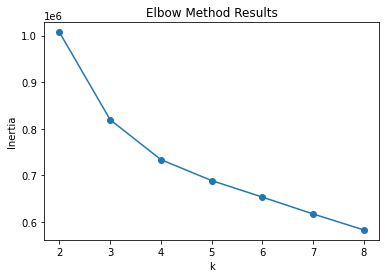

In [37]:
plt.figure()
plt.plot(k_df['k'], k_df['intertia'], marker = 'o')
plt.title('Elbow Method Results')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.show()

When interpreting the results of these four tests, one can see that from a mathmatical perspective, Silhoutte and Calinsk-Harabasz scores looked best at K = 2, while the inertia results inferred that there was a plateu at K = 3. There is a tradeoff in picking one K over another. If one were to chose K= 2, yes they may have a tighter clustering, but the results will be less meaningful as the clustering is too coarse. If one were to choose K= 3, that would mean there would be a greater workload differentiation, potentially giving a more meaningful result. 

For this specific project, I want to see a more meaningful distinction between cluster groupings, so I am going to go with the elbow method result, showing that we plateau at K = 3. 

In [38]:
best_k = 3
print('Best K is: ', best_k)

Best K is:  3


Now running KMeans on K = 3 and viewing the results below

In [39]:
kmeans_best = KMeans(n_clusters = best_k, n_init=10, random_state = 42)
label_best = kmeans_best.fit_predict(X_sdf)

In [40]:
if not metadata.index.name == 'vm_unique_id':
    metadata = metadata.set_index('vm_unique_id')

cluster_n = (pd.DataFrame({'vm_unique_id': X.index, 'cluster': label_best, 'pca_x': X_pca[:, 0], 
                           'pca_y': X_pca[:, 1],
}).set_index('vm_unique_id').join(metadata, how = 'left'))

print('\nK Means Cluster Count: ')
print(cluster_n['cluster'].value_counts())


K Means Cluster Count: 
2    22514
1    17894
0     3221
Name: cluster, dtype: int64


Visualizing the results of the cluster split below via PCA projection in 2D as well as 3D. 

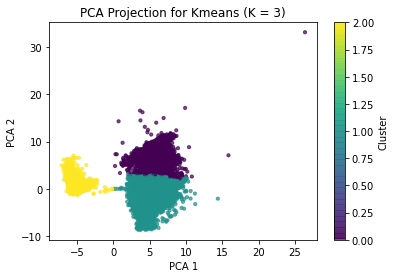

In [41]:
pca = PCA(n_components = 2, random_state = 42)
X_pca = pca.fit_transform(X_sdf)

plt.figure()
plt.scatter(X_pca[:, 0], X_pca[:, 1], c = cluster_n['cluster'], cmap = 'viridis',s = 10, alpha = 0.7)

plt.title('PCA Projection for Kmeans (K = 3)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar(label = 'Cluster')
plt.show() 

The below code adds a third dimension to the data to for better visualization of the cluster separation. 

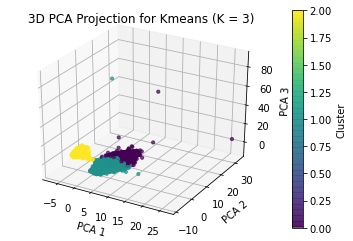

In [42]:
pca = PCA(n_components = 3, random_state = 42)
X_pca = pca.fit_transform(X_sdf)

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c = cluster_n['cluster'], cmap = 'viridis', 
                      s = 10, alpha = 0.7)

ax.set_title('3D PCA Projection for Kmeans (K = 3)')
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')
plt.colorbar(scatter, label = 'Cluster')
plt.show()

In [43]:
df_cluster = X_sdf.copy()
df_cluster['cluster'] = label_best

cluster_means = (df_cluster.groupby('cluster').mean(numeric_only = True).T.sort_index())

clust_feat = (cluster_means.apply(lambda col: col.abs(), axis = 0).mean(axis=1).sort_values(ascending = False)
             .head(15).index)

clust_15 = cluster_means.loc[clust_feat]


Finally, viewing the separation of these clusters, by the top 10 tests that were presented per VM grouping. More discussion on what these tests mean will be done in the results/analysis section, but as one can see, there is a very clear distinction between the top tests in each category. 

In [44]:
for c in cluster_means.columns:
    print(f'\n Cluster {c}: Top 10 Features')
    display(cluster_means.loc[:, c].nlargest(10))


 Cluster 0: Top 10 Features


test_name
Scaling_Factor:_2500_-_Clients:_1_-_Mode:_Read_Write_(TPC-B_Like)_-_Average_Latency    2.248192
Scaling_Factor:_2500_-_Clients:_1_-_Mode:_Read_Only_-_Average_Latency                  2.040172
Scaling_Factor:_25_-_Clients:_25_-_Mode:_Read_Only_-_Average_Latency                   1.989962
Scaling_Factor:_25_-_Clients:_1_-_Mode:_Read_Only_-_Average_Latency                    1.799757
Test:_Create_Files                                                                     1.665894
Scaling_Factor:_25_-_Clients:_1_-_Mode:_Read_Write_(TPC-B_Like)_-_Average_Latency      1.626801
Test:_Idle_Latency                                                                     1.394102
Scaling_Factor:_25_-_Clients:_25_-_Mode:_Read_Write_(TPC-B_Like)_-_Average_Latency     1.264558
Test:_Memory_Allocations                                                               1.219705
Test:_Create_Processes                                                                 1.125068
Name: 0, dtype: float64


 Cluster 1: Top 10 Features


test_name
Test:_Max_Bandwidth_-_All_Reads                      1.086263
Test:_Peak_Injection_Bandwidth_-_All_Reads           1.068407
Test:_Max_Bandwidth_-_3:1_Reads-Writes               1.003888
Test:_Peak_Injection_Bandwidth_-_3:1_Reads-Writes    0.973480
Test:_Create_Processes                               0.967233
Test:_Memory_Copying                                 0.954650
Test:_Memory_Allocations                             0.938517
Test:_Create_Threads                                 0.935757
Test:_Max_Bandwidth_-_1:1_Reads-Writes               0.909779
Test:_Max_Bandwidth_-_2:1_Reads-Writes               0.905740
Name: 1, dtype: float64


 Cluster 2: Top 10 Features


test_name
Benchmark:_Syscall_Basic                                                                             0.968006
Test:_SADD_-_Parallel_Connections:_50                                                                0.940918
Test:_SET_-_Parallel_Connections:_50                                                                 0.939142
Test:_LPUSH_-_Parallel_Connections:_50                                                               0.935783
Benchmark:_Epoll_Wait                                                                                0.934824
Test:_RAM__Memory                                                                                    0.919147
Test:_GET_-_Parallel_Connections:_50                                                                 0.909941
Scaling_Factor:_25_-_Clients:_1_-_Mode:_Read_Only                                                    0.897205
Scaling_Factor:_25_-_Clients:_1_-_Mode:_Read_Write_(TPC-B_Like)                                      0.882100


## Additional Modeling via GMM and Results of GMM

Finally, performing Gaussian Mixture modeling on the data to see how the clusters separate via this method compared to K-Means. As one can see, the GMM model gave a much lower silhoutte score than our K-Means model did. Understanding this, the K means modeling provides a more significant, well separated clustering result than the GMM model did

In [45]:
gmm = GaussianMixture(n_components = int(best_k), covariance_type = 'full', random_state = 42)
gmm_labels = (gmm.fit_predict(X_sdf))

cluster_gmm = (pd.DataFrame({'vm_unique_id': X.index, 'cluster': gmm_labels, 'pca_x': X_pca[:, 0], 
                           'pca_y': X_pca[:, 1],
}).set_index('vm_unique_id').join(metadata, how = 'left'))

print('\nGMM Cluster Count: ')
print(cluster_gmm['cluster'].value_counts())
print('Silhouette Score:', silhouette_score(X_sdf, gmm_labels))


GMM Cluster Count: 
0    21036
2    14956
1     7637
Name: cluster, dtype: int64
Silhouette Score: 0.38285665172088973


Again, using PCA projection of the model onto the clusters in 2D and 3D. 

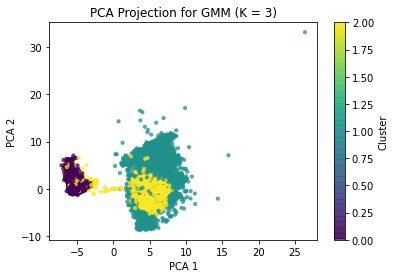

In [46]:
pca = PCA(n_components = 2, random_state = 42)
X_pca = pca.fit_transform(X_sdf)

plt.figure()
plt.scatter(X_pca[:, 0], X_pca[:, 1], c = cluster_gmm['cluster'], cmap = 'viridis',s = 10, alpha = 0.7)

plt.title('PCA Projection for GMM (K = 3)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar(label = 'Cluster')
plt.show()

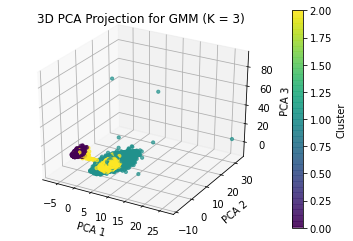

In [47]:
pca = PCA(n_components = 3, random_state = 42)
X_pca = pca.fit_transform(X_sdf)

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c = cluster_gmm['cluster'], cmap = 'viridis', 
                      s = 10, alpha = 0.7)

ax.set_title('3D PCA Projection for GMM (K = 3)')
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')
plt.colorbar(scatter, label = 'Cluster')
plt.show()

# 3.  Discussion of Results

In [48]:
sil_score = silhouette_score(X_sdf, label_best)
cluster_id = sorted(np.unique(label_best))
cluster_size = [(label_best == c).sum() for c in cluster_id]

metrics_5 = []
for c in cluster_id: 
    met = (cluster_means[c].abs().sort_values(ascending = False).head(5).index)
    metrics_5.append(", ".join(met))

clust_type = ["High Transactional Workloads", "CPU & Memory Intensive Workloads", "Syscall & Redis Workloads", ]

clust_sum = pd.DataFrame({"Cluster": cluster_id, "Cluster Size": cluster_size, "Top Metrics": metrics_5,
                         "Workload Type": clust_type,})

pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 200)

display(clust_sum.style.set_properties(**{'text-align': 'left', 'white-space': 'pre-wrap'}))

print('K Means Silhouette Score', sil_score)
#print(clust_sum)

,Cluster,Cluster Size,Top Metrics,Workload Type
0,0,3221,"Scaling_Factor:_2500_-_Clients:_1_-_Mode:_Read_Write_(TPC-B_Like)_-_Average_Latency, Scaling_Factor:_2500_-_Clients:_1_-_Mode:_Read_Only_-_Average_Latency, Scaling_Factor:_25_-_Clients:_25_-_Mode:_Read_Only_-_Average_Latency, Test:_Max_Bandwidth_-_Stream-Triad_Like, Scaling_Factor:_25_-_Clients:_1_-_Mode:_Read_Only_-_Average_Latency",High Transactional Workloads
1,1,17894,"Test:_Max_Bandwidth_-_All_Reads, Test:_Peak_Injection_Bandwidth_-_All_Reads, Test:_RAM__Memory, Benchmark:_Syscall_Basic, Test:_Max_Bandwidth_-_3:1_Reads-Writes",CPU & Memory Intensive Workloads
2,2,22514,"Benchmark:_Syscall_Basic, Test:_SADD_-_Parallel_Connections:_50, Test:_SET_-_Parallel_Connections:_50, Test:_LPUSH_-_Parallel_Connections:_50, Benchmark:_Epoll_Wait",Syscall & Redis Workloads


K Means Silhouette Score 0.5329497314015278


The above code summarizes the results of the Hyperparamtized K-Means clustering previously done and puts it in the above table. As one can see, it shows the breakdown of clusters into three separate groups (which was the most optimal choice for number of clusters), it shows the total cluster size, and the top 5 metrics with the largest weight in each cluster. 

The final column provides a bit of context into what those tests mean, and what workload type those tests with higher values would indicate. This required reading through brief test documentation to interpret the final results. 

As shown by the Silhouette score of 0.532, the clusters are relatively well separated, and aranged in a cohesive manner, while still mantaining separation. Compared to the Gaussian Mixture modeling, the silhouette score of the K-Means model showed a more significnt result.

One of the more important things to note is that the top benchmark tests (or metrics) were selected based on which had the highest values for each cluster. For example, if the features for a group of read/write IO tests were high in a certain cluster, these were weighted much higher than the rest. The grouping was done not on the count of tests done, but the actual weighted value of the test results. This is important to undertsand being that the top metrics will show where the cluster grouping scored the highest. 

In summary, the top tests for each cluster align with known performance patterns. Using the example of the "CPU & Memory Intensive Workloads" cluster, matrix math and bandwitdth tests correspond to CPU. This example shows that the clusters actually reflect meaningful workload types, rather than arbitray groupings. As this is an unsupervised task, and no labels were in the data, these interepretations have to be inferenced rather than taken directly from known labels themselves. 

# 4. Conclusion

This data provided a rich abundance of benchmark tests for the Hyperparamter Tuned K-Means model to cluster on. The final K-Means model (with K = 3) succesfully clustered ~43,000 Azure VMs into different workload patterns with an overall silhouette score of 0.532. 

Grouping clusters based on the results of these benchmark tests provided insightful results and an oppurtunity for future VM modeling. This modeling technique could be a novel way for cloud service providers, who run these type of benchmark tests regularly, to cluster VMs based on similar workload patterns and place them on physical hosts that will meet the specific need of their workload. For example, using the actual clustering that was done above, the CPU/Memory intensive workload type may be prioritized to be put on a physical host with greater CPU and Memory than the rest. 

A few interesting ideas for future work include:

1. Quantifying the actual need of these workloads into real CPU, MEM (GB), and IO (op/sec) requirements- This would be a logical next step beyond profiling them into groups. This would provide more actionable insights, as it would provide a cloud service provider to actually size the physical hosts needed

2. Using NLP to interpret the results of of test benchmarks rather than having to go through documentation to understand what the meaning of the results are- In the current modeling process, individual tests, whose values were weighted the highest, are given as top test results for each cluster. This requires an individual to read through the test documentation to infer what each benchmark actually tests for. Using an NLP model to interpre these results would be a novel idea.

3. Gaining further insight into the temporal nature of workloads- Currently the data is stripped of its temporal nature to provide per metric/per VM insights. This was necesary to due given the nature of the model and the nature of the data, but it would be interesting to work with data in the future with longer running temporal features, so that one could actually analyze the change in test results over time. This would provide another dimension to the analysis that could yield interesting results.

# 5. References

1. Johannes Freischuetz, Konstantinos Kanellis, Brian Kroth, and Shivaram Venkataraman. 2025.  
TUNA: Tuning Unstable and Noisy Cloud Applications.  
In Proceedings of the Twentieth European Conference on Computer Systems (EuroSys '25).  
Association for Computing Machinery, New York, NY, USA  

2. VanderPlas, J. (n.d.). In Depth: Principal component analysis. Python Data Science Handbook. Retrieved from https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html

3. OpenAI. (2025). ChatGPT (version GPT-5) [Large language model]. OpenAI. (Used for error trace debugging and function usage examples.)

4. Google DeepMind. (2025). Gemini [Large language model]. Google DeepMind. (Used for error trace debugging and function usage examples.)

5. Codecademy. (n.d.). Clustering: K-Means cheatsheet. Retrieved from https://www.codecademy.com/learn/dspath-unsupervised/modules/dspath-clustering/cheatsheet

6. Yehoshua, R. (n.d.). Gaussian mixture models (GMMs) – From theory to implementation. Towards Data Science. Retrieved from https://towardsdatascience.com/gaussian-mixture-models-gmms-from-theory-to-implementation-4406c7fe9847/